In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters 
signal_level = 2000       # photons 
background_level = 500    # photons 
read_noise = 30           # photons 
n_realizations = 100000   # Monte Carlo samples


# Simulate
# photon noise: star + background
photon_counts = np.random.poisson(signal_level + background_level, size=n_realizations)

# readout noise (Gaussian)
readout = np.random.normal(0, read_noise, size=n_realizations)

# total measured signal
measured = photon_counts + readout


# Statistics
mean_sim = np.mean(measured)
var_sim = np.var(measured)

print("----- Results -----")
print(f"Mean :     {mean_sim:.2f}")
print(f"Variance : {var_sim:.2f}")



expected_variance = (signal_level + background_level) + read_noise**2
print("----- Expected Noise Model -----")
print(f"Expected variance = signal + background + read_noise^2")
print(f"Expected variance:     {expected_variance:.2f}")
print(f"Difference:            {var_sim - expected_variance:.2f}")

----- Results -----
Mean :     2499.79
Variance : 3398.84
----- Expected Noise Model -----
Expected variance = signal + background + read_noise^2
Expected variance:     3400.00
Difference:            -1.16


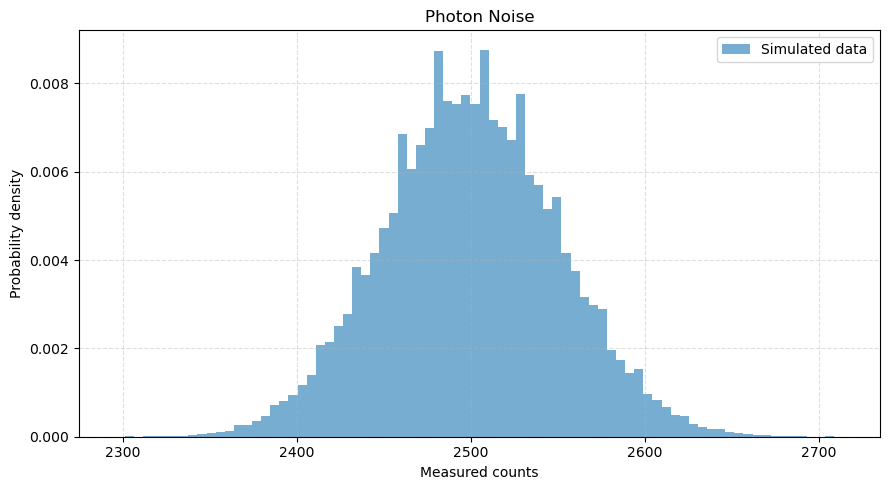

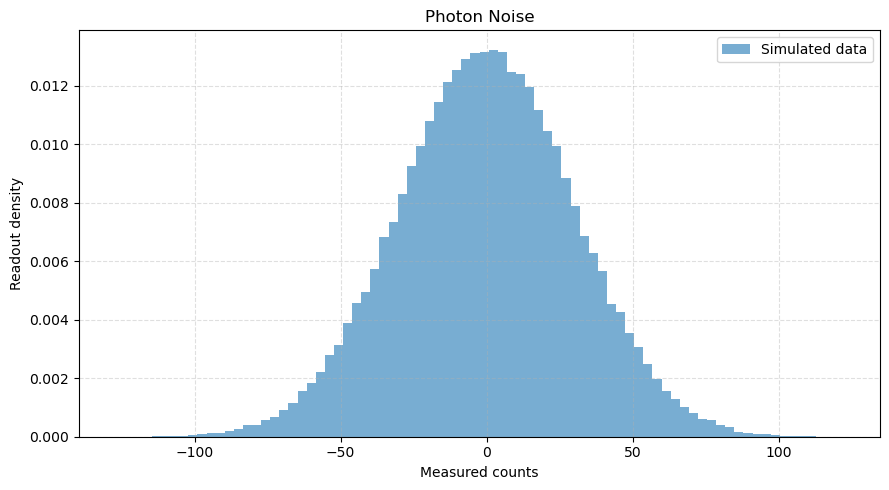

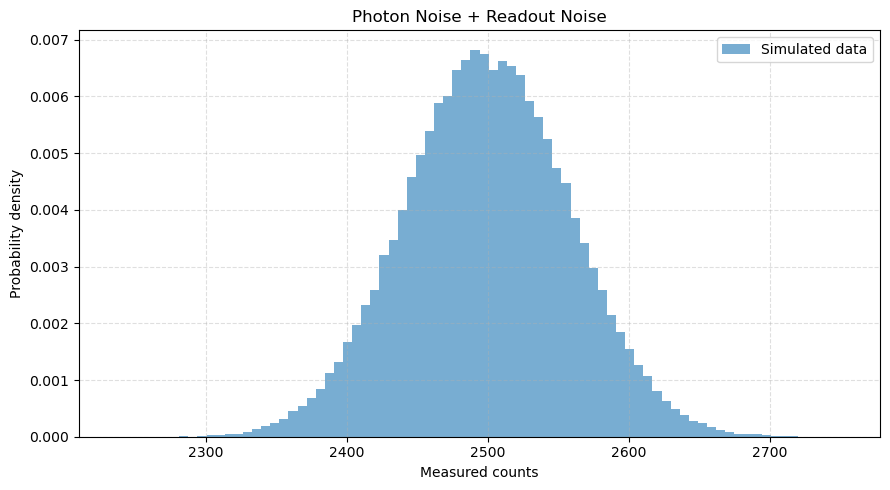

In [96]:

# Plot histogram

#photon noise
plt.figure(figsize=(9,5))
plt.hist(photon_counts, bins=80, density=True, alpha=0.6, label='Simulated data')
plt.xlabel("Measured counts")
plt.ylabel("Probability density")
plt.title("Photon Noise")
plt.grid(True, ls="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

#readout noise
plt.figure(figsize=(9,5))
plt.hist(readout, bins=80, density=True, alpha=0.6, label='Simulated data')
plt.xlabel("Measured counts")
plt.ylabel("Readout density")
plt.title("Photon Noise")
plt.grid(True, ls="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

#total
plt.figure(figsize=(9,5))
plt.hist(measured, bins=80, density=True, alpha=0.6, label='Simulated data')
plt.xlabel("Measured counts")
plt.ylabel("Probability density")
plt.title("Photon Noise + Readout Noise")
plt.grid(True, ls="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


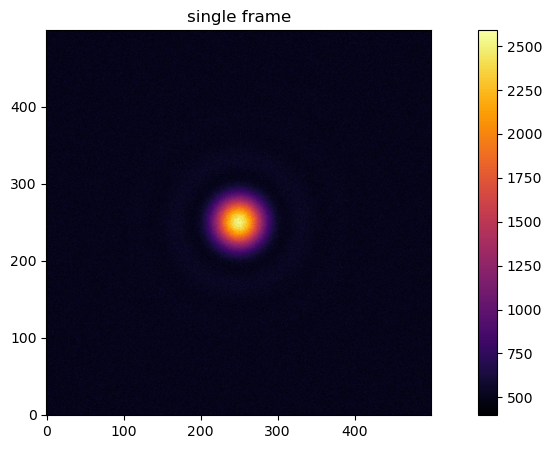

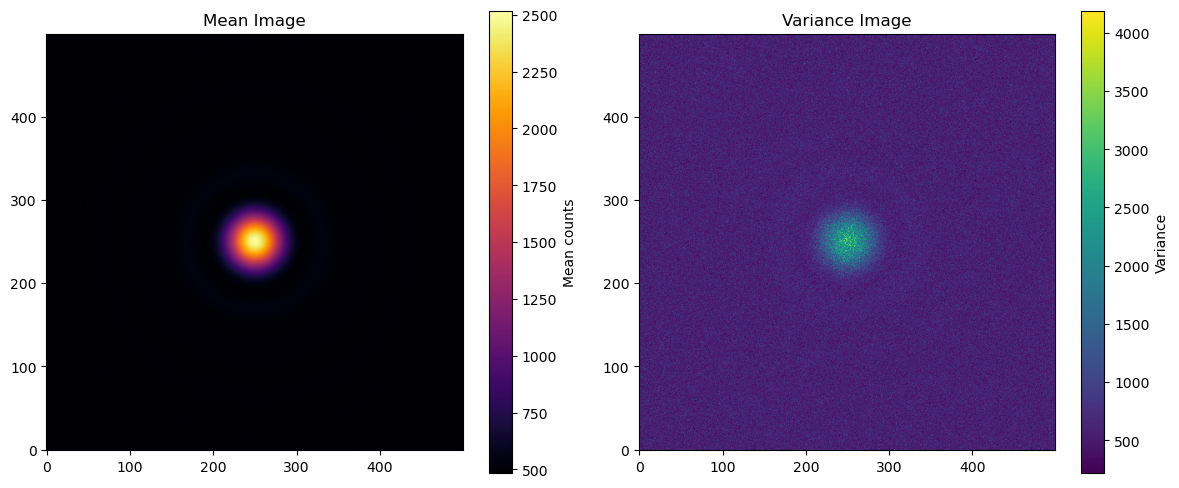

mean_value 524.5465278123319
var_value 611.6972786579494
expected_var 624.5465278123319


In [97]:
from hcipy import *

diam = 1.52
pupil_grid = make_pupil_grid(240, diam)
ap_gen = make_obstructed_circular_aperture(diam, 0, 0, 0)
aperture = evaluate_supersampled(ap_gen, pupil_grid, 4)

wavelength = 1700e-9
focal_grid = make_focal_grid(q=50, num_airy=5,
                             spatial_resolution=wavelength/diam)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

wf = Wavefront(aperture, wavelength=wavelength)
psf = prop.forward(wf).power
psf_2d = psf.shaped

# Normalize so max = 2000 photons and add background
background = 500
psf = psf / psf.max() * 2000 + background

# Detector on focal grid
read_noise = 10
camera = NoisyDetector(
    focal_grid,
    read_noise=read_noise,
    flat_field=0,
    include_photon_noise=True,
)

# Generate image cube
N = 50
cube = []

for i in range(N):
    
    # Integrate (exposure = 0.005 seconds)
    camera.integrate(psf, 1)
    frame = camera.read_out()
    cube.append(frame.shaped)

cube = np.array(cube)

plt.figure(figsize=(12,5))
plt.imshow(frame.shaped, origin='lower', cmap='inferno')
plt.title('single frame')
plt.colorbar()
plt.show()

mean_image = np.mean(cube, axis=0)
var_image = np.var(cube, axis=0)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(mean_image, origin='lower', cmap='inferno')
plt.colorbar(label='Mean counts')
plt.title('Mean Image')
plt.subplot(1,2,2)
plt.imshow(var_image, origin='lower', cmap='viridis')
plt.colorbar(label='Variance')
plt.title('Variance Image')
plt.tight_layout()
plt.show()

mean_value = np.mean(mean_image)
var_value = np.mean(var_image)
expected_var = mean_value + read_noise**2
print('mean_value', mean_value)
print('var_value' ,var_value)
print('expected_var', expected_var)

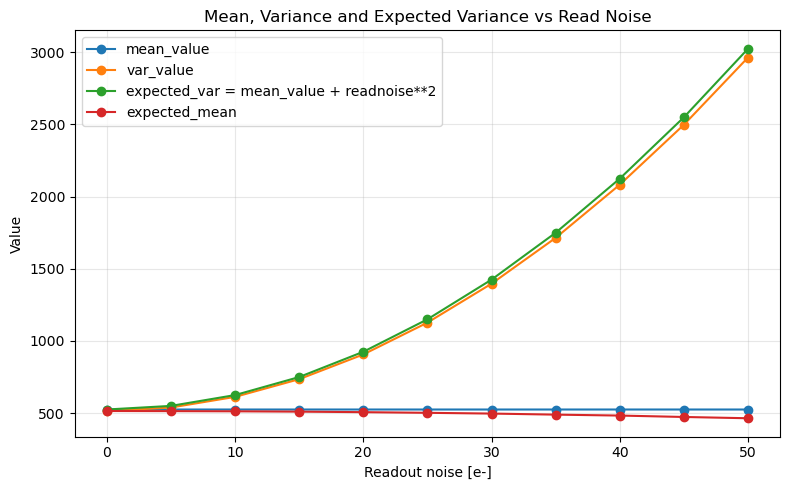

In [98]:
read_noises = np.arange(0, 51, 5) 

mean_values = []
var_values = []
expected_vars = []
expected_means = []

N = 50   # number of frames in cube

for read_noise in read_noises:
    camera = NoisyDetector(
        focal_grid,
        read_noise=read_noise,
        flat_field=0,
        include_photon_noise=True
    )

    cube = []
    for i in range(N):
        camera.integrate(psf, 1)
        cube.append(camera.read_out().shaped)

    cube = np.array(cube)

    mean_image = np.mean(cube, axis=0)
    var_image = np.var(cube, axis=0)

    mean_value = np.mean(mean_image)
    var_value = np.mean(var_image)
    expected_var = mean_value + read_noise**2
    expected_mean = np.mean(var_image - read_noise**2)

    mean_values.append(mean_value)
    var_values.append(var_value)
    expected_vars.append(expected_var)
    expected_means.append(expected_mean)

# -------------------------------------------------------
# Plot results
# -------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(read_noises, mean_values, 'o-', label='mean_value')
plt.plot(read_noises, var_values, 'o-', label='var_value')
plt.plot(read_noises, expected_vars, 'o-', label='expected_var = mean_value + readnoise**2')
plt.plot(read_noises, expected_means, 'o-', label='expected_mean')
plt.xlabel("Readout noise [e-]")
plt.ylabel("Value")
plt.title("Mean, Variance and Expected Variance vs Read Noise")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
